In [1]:
# Meant to be used on Google Colab
!git clone https://github.com/alextongdo/cse253-assignment2.git
%cd cse253-assignment2

Cloning into 'cse253-assignment2'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 20 (delta 2), reused 20 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (20/20), 5.86 MiB | 19.12 MiB/s, done.
Resolving deltas: 100% (2/2), done.
/home/atn021/private/cse253/assignment2/cse253-assignment2


In [ ]:
# Meant to be used on Google Colab
!unzip data/lofi/lofi-100.zip -d data/lofi
!unzip data/soundcloud/peaceful-piano-midi/peaceful-piano-midis.zip -d data/soundcloud/peaceful-piano-midi
!unzip data/pop-music-transformer/train/pop-music-transformer-train.zip -d data/pop-music-transformer/train

In [3]:
# Meant to be used on Google Colab
!nvidia-smi 2>/dev/null || echo "No GPU available"  # check GPU

Sat May 31 09:16:51 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.08             Driver Version: 535.161.08   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off | 00000000:DA:00.0 Off |                  N/A |
|  0%   25C    P8              18W / 250W |      0MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
%pip install miditok
%pip install symusic
%pip install torch
%pip install transformers
%pip install accelerate
%pip install evaluate
%pip install tensorboard
%pip install scikit-learn
%pip install frechet-music-distance

import os
import math
import torch
import random
import music21
import torch.nn as nn
from glob import glob
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
from random import shuffle
import matplotlib.pyplot as plt
from collections import defaultdict
from evaluate import load as load_metric

from miditok import REMI, TokenizerConfig
from miditok.pytorch_data import DatasetMIDI, DataCollator
from miditok.utils import split_files_for_training
from torch import Tensor, argmax
from torch.utils.data import DataLoader, random_split
from torch.cuda import is_available as cuda_available, is_bf16_supported
from torch.backends.mps import is_available as mps_available
from transformers import AutoModelForCausalLM, MistralConfig, Trainer, TrainingArguments, GenerationConfig
from transformers.trainer_utils import set_seed
from frechet_music_distance import FrechetMusicDistance

### Basic Data Analysis

In [ ]:
def basic_data_analysis(path_list: list[str], dataset_name: str) -> None:
    score_list = [music21.converter.parse(mid) for mid in tqdm(path_list, desc="Parsing MIDIs")]

    # Dataset Length
    print(f"Length of {dataset_name} Dataset: {len(path_list)}")

    # Key Signature Distribution
    key_counts = defaultdict(int)
    for score in score_list:
        key = score.analyze('key')
        key_counts[str(key)] += 1
    key_counts = dict(sorted(key_counts.items()))

    # Time Signature Distribution
    time_sig_counts = defaultdict(int)
    for score in score_list:
        for ts in score.getTimeSignatures():
            time_sig_counts[f"{ts.beatCount}/{ts.denominator}"] += 1
    time_sig_counts = dict(sorted(time_sig_counts.items()))

    # Num Tracks Distribution
    num_track_counts = defaultdict(int)
    for score in score_list:
        num_tracks = len(score.parts)
        num_track_counts[str(num_tracks)] += 1
    num_track_counts = dict(sorted(num_track_counts.items()))

    # Tempo Distribution
    tempo_counts = defaultdict(int)
    for score in score_list:
        for tempo in score.recurse().getElementsByClass(music21.tempo.MetronomeMark):
            tempo_counts[float(tempo.number) if tempo is not None else "None"] += 1
    tempo_counts = dict(sorted(tempo_counts.items()))

    # Pitch Class Distribution
    pitch_class_counts = defaultdict(int)
    for score in score_list:
        notes = score.flatten().notes
        for n in notes:
            if isinstance(n, music21.note.Note):
                pitch_class_counts[str(n.pitch.name)] += 1
    pitch_class_counts = dict(sorted(pitch_class_counts.items()))

    # Duration Distribution
    duration_counts = defaultdict(int)
    for score in score_list:
        duration = score.duration.quarterLength
        duration_counts[int(duration)] += 1
    duration_counts = dict(sorted(duration_counts.items()))

    fig, axs = plt.subplots(2, 3, figsize=(18, 8))
    axs[0][0].bar(key_counts.keys(), key_counts.values())
    axs[0][0].set_xlabel('Key Signature')
    axs[0][0].set_ylabel('Count')
    axs[0][0].set_xticks(list(key_counts.keys()))
    axs[0][0].tick_params(axis='x', rotation=45)
    axs[0][0].set_title('Key Signature Distribution')

    axs[0][1].bar(time_sig_counts.keys(), time_sig_counts.values())
    axs[0][1].set_xlabel('Time Signature')
    axs[0][1].set_ylabel('Count')
    axs[0][1].set_xticks(list(time_sig_counts.keys()))
    axs[0][1].set_title('Time Signature Distribution')

    axs[0][2].bar(num_track_counts.keys(), num_track_counts.values())
    axs[0][2].set_xlabel('Number of Tracks')
    axs[0][2].set_ylabel('Count')
    axs[0][2].set_xticks(list(num_track_counts.keys()))
    axs[0][2].set_title('Number of Tracks Distribution')

    axs[1][0].hist(list(tempo_counts.keys()), weights=list(tempo_counts.values()), bins=20)
    axs[1][0].set_xlabel('Tempo (BPM)')
    axs[1][0].set_ylabel('Count')
    axs[1][0].set_title('Tempo Distribution')

    axs[1][1].bar(pitch_class_counts.keys(), pitch_class_counts.values())
    axs[1][1].set_xlabel('Pitch Class')
    axs[1][1].set_ylabel('Count')
    axs[1][1].set_xticks(list(pitch_class_counts.keys()))
    axs[1][1].set_title('Pitch Class Distribution')

    axs[1][2].hist(list(duration_counts.keys()), weights=list(duration_counts.values()), bins=20)
    axs[1][2].set_xlabel('Duration (in quarter notes)')
    axs[1][2].set_ylabel('Count')
    axs[1][2].set_title('Duration Distribution')

    plt.tight_layout()
    plt.show()

#### Pop Music Transformer Trainset

Parsing MIDIs: 100%|██████████| 775/775 [03:10<00:00,  4.07it/s]


Length of Pop Music Transformer Dataset: 775


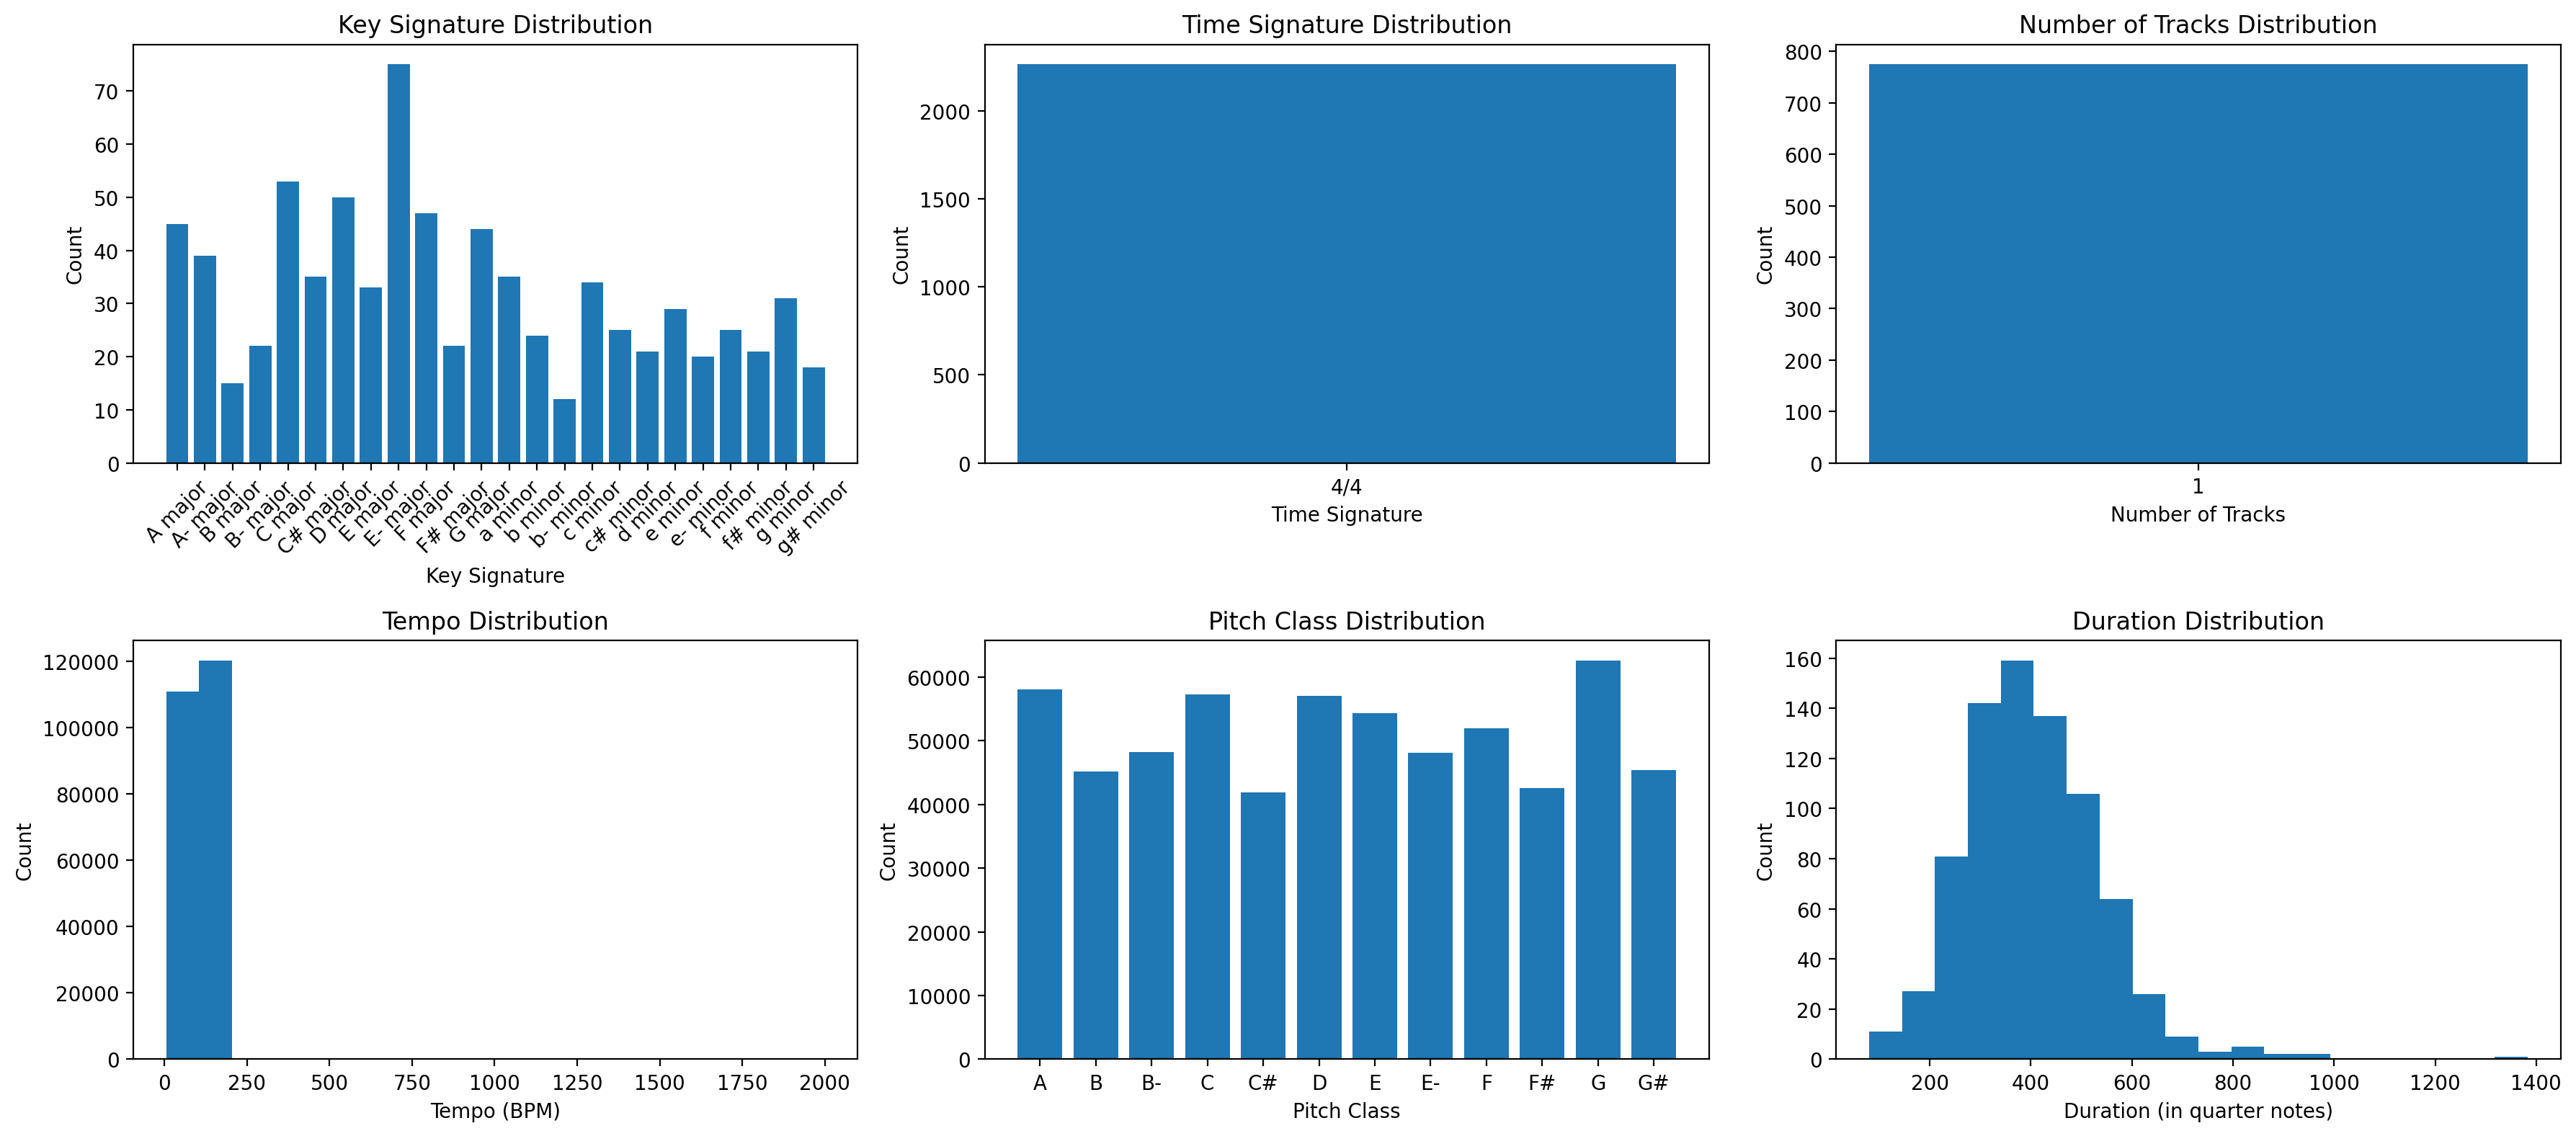

In [ ]:
POP_MUSIC_TRANSFORMER = glob("data/pop-music-transformer/train/*.midi")
basic_data_analysis(POP_MUSIC_TRANSFORMER, "Pop Music Transformer")

#### LOFI ~100 Dataset

Parsing MIDIs: 100%|██████████| 103/103 [00:00<00:00, 307.31it/s]


Length of LOFI ~100 Dataset: 103


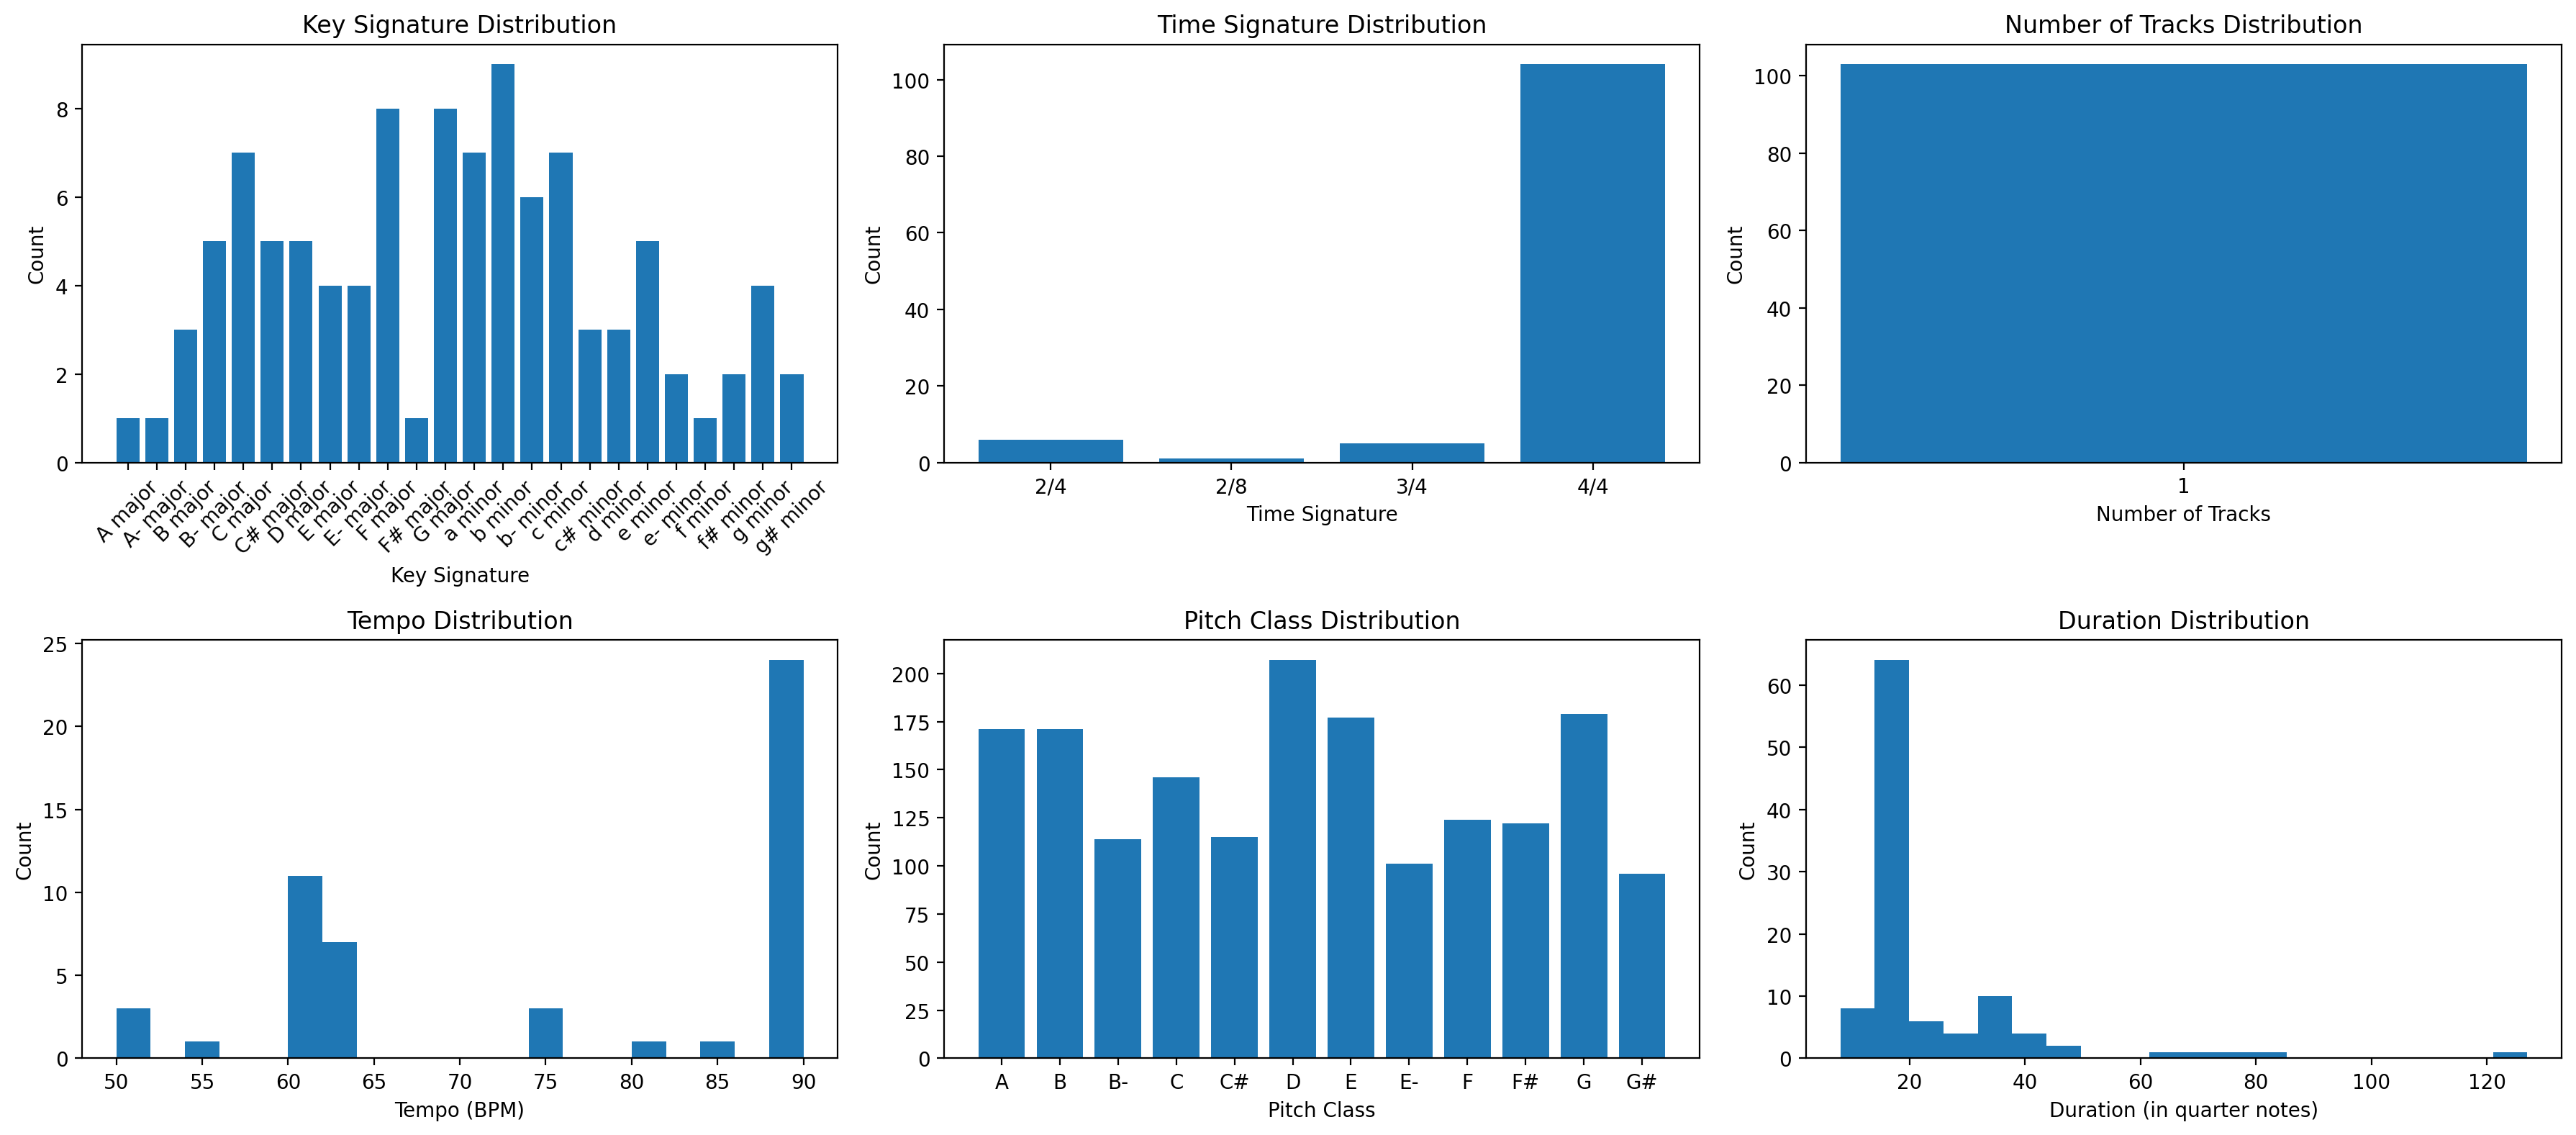

In [ ]:
LOFI_100 = glob("data/lofi/*.mid")
basic_data_analysis(LOFI_100, "LOFI ~100")

#### LOFI Peaceful Piano Dataset

Parsing MIDIs: 100%|██████████| 261/261 [00:38<00:00,  6.86it/s]


Length of LOFI Peaceful Piano Dataset: 261


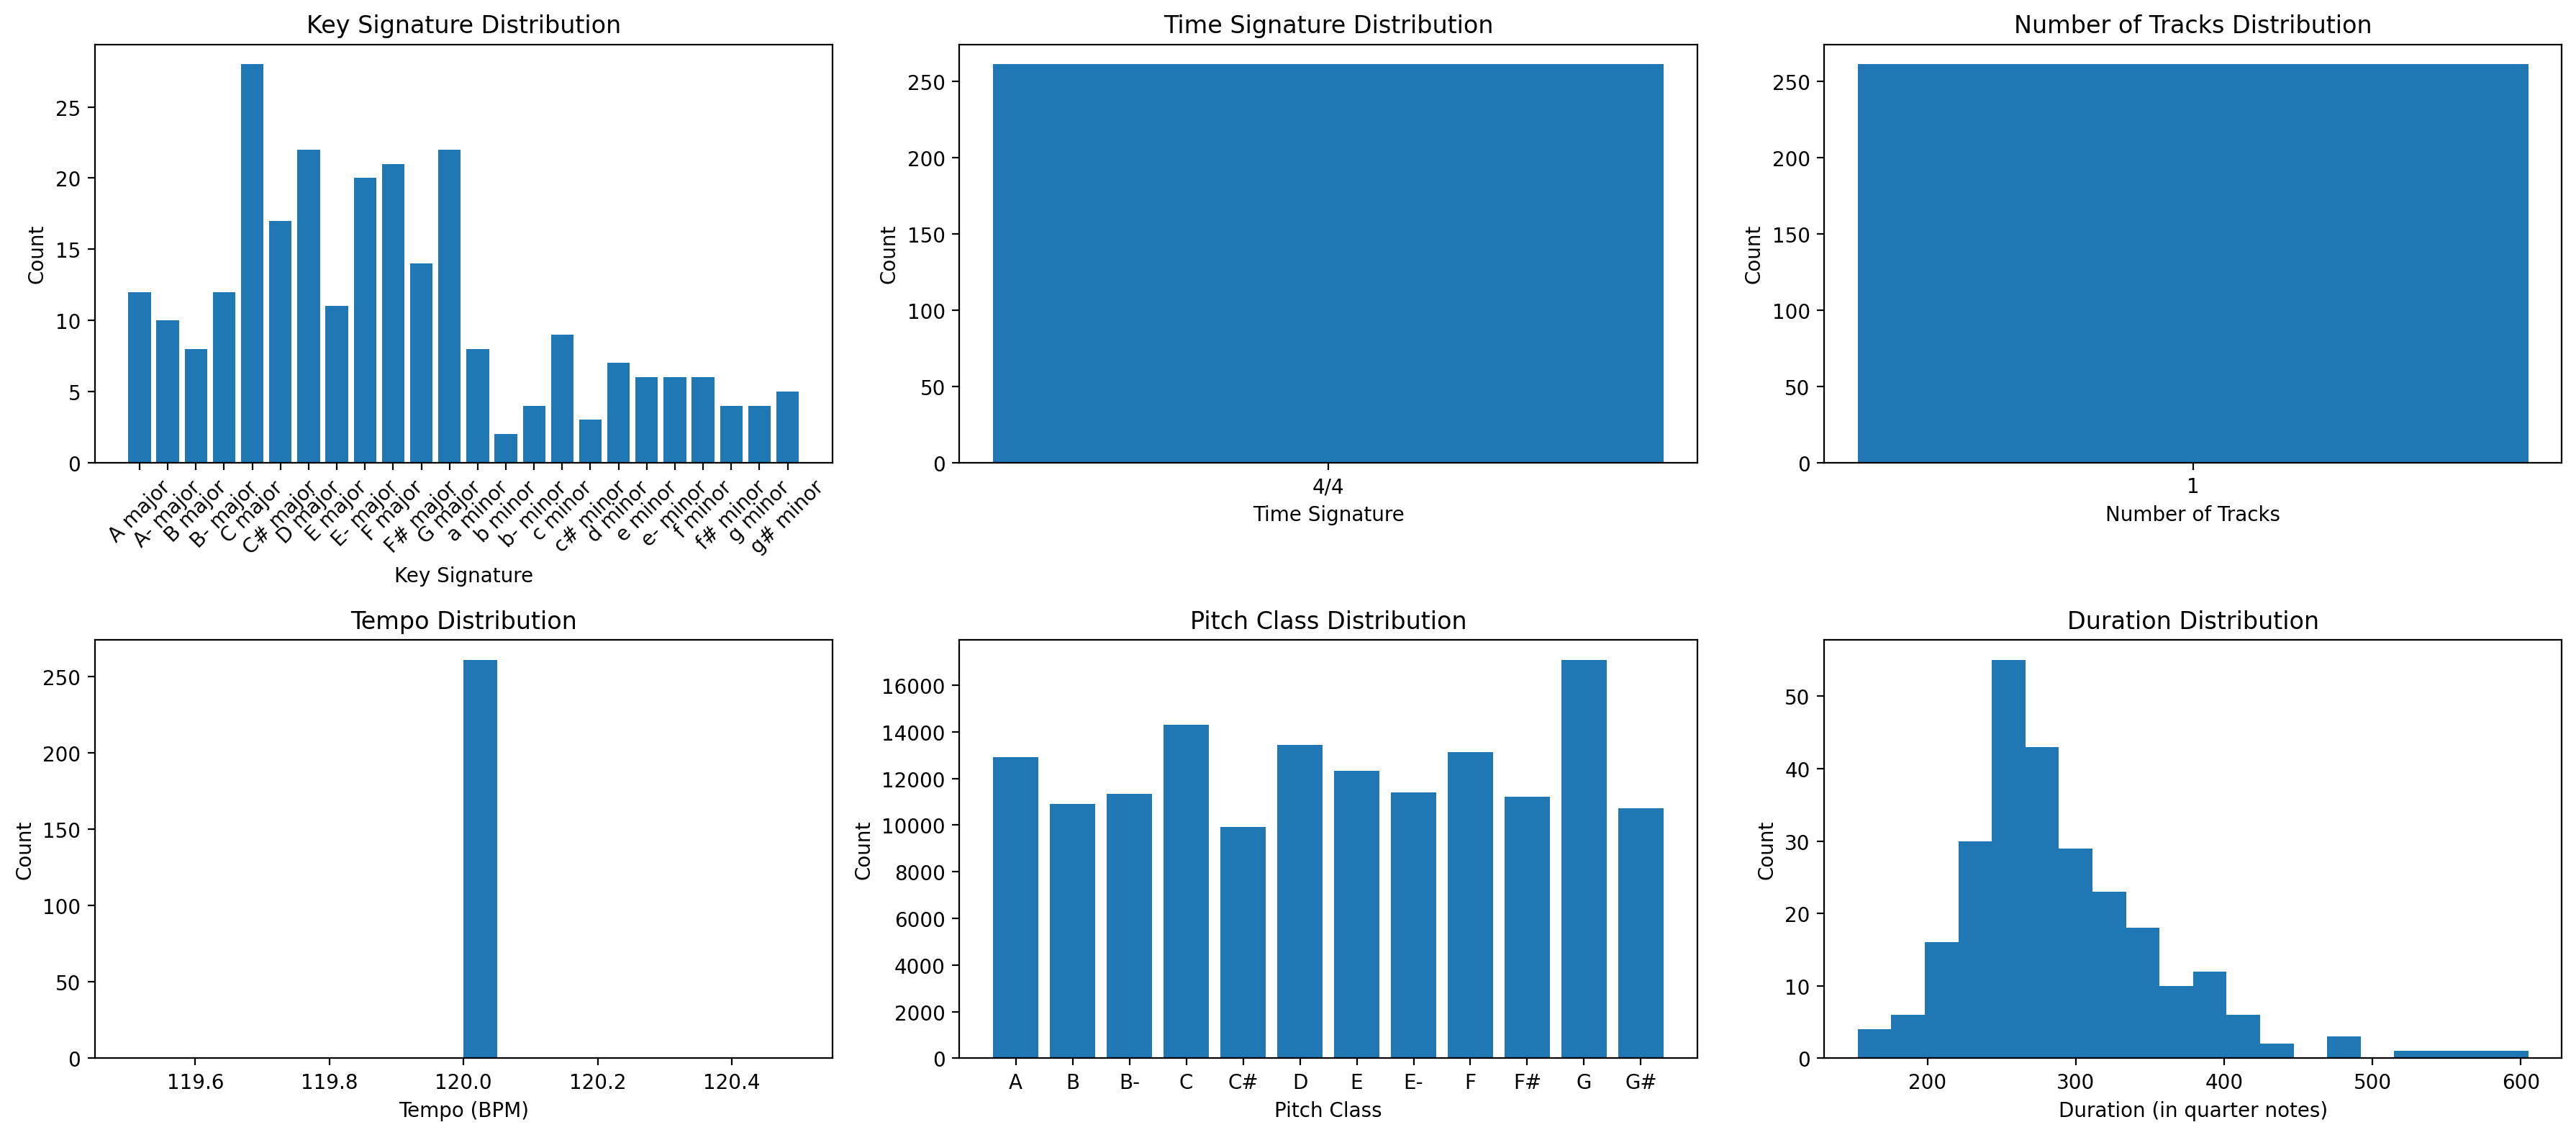

In [ ]:
LOFI_PEACEFUL_PIANO = glob("data/soundcloud/peaceful-piano-midi/*.mid")
basic_data_analysis(LOFI_PEACEFUL_PIANO, "LOFI Peaceful Piano")

In [6]:
POP_MUSIC_TRANSFORMER = glob("data/pop-music-transformer/train/*.midi")
LOFI_100 = glob("data/lofi/*.mid")
LOFI_PEACEFUL_PIANO = glob("data/soundcloud/peaceful-piano-midi/*.mid")

In [ ]:
TOKENIZER_PARAMS = {
    "num_velocities": 16,
    "use_chords": True,
    "use_rests": True,
    "use_tempos": True,
    "use_pitchdrum_tokens": False,
}
config = TokenizerConfig(**TOKENIZER_PARAMS)
tokenizer = REMI(config)

### Pre-trained Mistral REMI

In [9]:
if not os.path.exists("preprocessed/pop-music-transformer"):
    split_files_for_training(
        files_paths=[Path(path).resolve() for path in POP_MUSIC_TRANSFORMER],
        tokenizer=tokenizer,
        save_dir=Path("preprocessed/pop-music-transformer"),
        max_seq_len=1024
    )

Splitting music files (preprocessed/pop-music-transformer): 100%|██████████| 775/775 [00:04<00:00, 157.61it/s]


In [ ]:
SPLIT_RATIO = 0.8

all_train = DatasetMIDI(
    files_paths=glob("preprocessed/pop-music-transformer/*.midi"),
    tokenizer=tokenizer,
    max_seq_len=1024,
    bos_token_id=tokenizer["BOS_None"],
    eos_token_id=tokenizer["EOS_None"],
)

total_len = len(all_train)
train_len = int(total_len * SPLIT_RATIO)
valid_len = total_len - train_len
dataset_train, dataset_valid = random_split(all_train, [train_len, valid_len])

In [11]:
model_config = MistralConfig(
    vocab_size=len(tokenizer),
    hidden_size=256,
    intermediate_size=1024,
    num_hidden_layers=4,
    num_attention_heads=4,
    num_key_value_heads=2,
    sliding_window=256,
    max_position_embeddings=2048,
    pad_token_id=tokenizer['PAD_None'],
    bos_token_id=tokenizer['BOS_None'],
    eos_token_id=tokenizer['EOS_None'],
)
model = AutoModelForCausalLM.from_config(model_config)

In [ ]:
metrics = {metric: load_metric(metric) for metric in ["accuracy"]}

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    not_pad_mask = labels != -100
    labels, predictions = labels[not_pad_mask], predictions[not_pad_mask]
    return metrics["accuracy"].compute(predictions=predictions.flatten(), references=labels.flatten())

def preprocess_logits(logits: Tensor, _: Tensor) -> Tensor:
    pred_ids = argmax(logits, dim=-1)  # long dtype
    return pred_ids

# Create config for the Trainer
USE_CUDA = cuda_available()
if not cuda_available():
    FP16 = FP16_EVAL = BF16 = BF16_EVAL = False
elif is_bf16_supported():
    BF16 = BF16_EVAL = True
    FP16 = FP16_EVAL = False
else:
    BF16 = BF16_EVAL = False
    FP16 = FP16_EVAL = True
USE_MPS = not USE_CUDA and mps_available()
training_config = TrainingArguments(
    output_dir="runs",
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,
    num_train_epochs=20,
    learning_rate=1e-4,
    weight_decay=0.01,
    max_grad_norm=1.0,
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,
    no_cuda=not USE_CUDA,
    seed=42,
    fp16=True,
    bf16=False,
    load_best_model_at_end=True,
    label_smoothing_factor=0.0,
    optim="adamw_torch",
    report_to=["tensorboard"],
    gradient_checkpointing=True,
)

collator = DataCollator(tokenizer["PAD_None"], copy_inputs_as_labels=True)
trainer = Trainer(
    model=model,
    args=training_config,
    data_collator=collator,
    train_dataset=dataset_train,
    eval_dataset=dataset_valid,
    compute_metrics=compute_metrics,
    callbacks=None,
    preprocess_logits_for_metrics=preprocess_logits,
)

# Training
train_result = trainer.train()
trainer.save_model()  # Saves the tokenizer too
trainer.log_metrics("train", train_result.metrics)
trainer.save_metrics("train", train_result.metrics)
trainer.save_state()

/opt/conda/lib/python3.11/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch,Training Loss,Validation Loss,Accuracy
1,5.858700,5.427667,0.011149
2,4.795500,4.312375,0.000051
3,3.953600,3.663714,0.000026
4,3.485900,3.360072,0.000036
5,3.239600,3.182656,0.000002
6,3.087800,3.073100,0.000000
7,2.980000,2.990730,0.000002
8,2.896500,2.934363,0.000002
9,2.825900,2.883722,0.000002
10,2.767600,2.849859,0.000007


***** train metrics *****
  epoch                    =       20.0
  total_flos               =  1169663GF
  train_loss               =     3.0961
  train_runtime            = 0:28:13.20
  train_samples_per_second =     30.239
  train_steps_per_second   =       1.89


In [ ]:
(gen_results_path := Path('gen_res')).mkdir(parents=True, exist_ok=True)

generation_config = GenerationConfig(
    max_new_tokens=200,  # generates 200 tokens from scratch
    num_beams=1,
    do_sample=True,
    temperature=0.9,
    top_k=15,
    top_p=0.95,
    epsilon_cutoff=3e-4,
    eta_cutoff=1e-3,
    pad_token_id=tokenizer.pad_token_id,
)

model.eval()

# Generate samples one at a time
num_samples = 50

count = 0
for i in tqdm(range(num_samples), desc='Generating unconditioned samples'):
    start_tokens = torch.tensor([[tokenizer['BOS_None']]])
    attention_mask = torch.ones_like(start_tokens)
    with torch.no_grad():
        generated_sequence = model.generate(
            inputs=start_tokens.to(model.device),
            attention_mask=attention_mask.to(model.device),
            generation_config=generation_config
        )
    generated_tokens = generated_sequence[0]
    midi = tokenizer.decode([generated_tokens.tolist()])
    tokens = [generated_tokens.tolist()]
    midi.dump_midi(gen_results_path / f'{count}.mid')
    tokenizer.save_tokens(tokens, gen_results_path / f'{count}.json')
    count += 1

print(f"Generated {count} unconditioned samples")

Generating unconditioned samples: 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]

Generated 10 unconditioned samples


In [ ]:
# Objective Evaluation
metric = FrechetMusicDistance(feature_extractor='clamp2', gaussian_estimator='mle', verbose=True)
score = metric.score(
    reference_path="gen_res",
    test_path="data/lofi"
)
print("Frechet Music Distance:", score)

### Fine-tune on Lo-fi ~100 + Lo-fi Peaceful Piano

In [ ]:
if not os.path.exists("preprocessed/lofi-100"):
    split_files_for_training(
        files_paths=[Path(path).resolve() for path in LOFI_100],
        tokenizer=tokenizer,
        save_dir=Path("preprocessed/lofi-100"),
        max_seq_len=1024
    )
if not os.path.exists("preprocessed/peaceful-piano"):
    split_files_for_training(
        files_paths=[Path(path).resolve() for path in LOFI_PEACEFUL_PIANO],
        tokenizer=tokenizer,
        save_dir=Path("preprocessed/peaceful-piano"),
        max_seq_len=1024
    )

In [ ]:
SPLIT_RATIO = 0.8

all_train = DatasetMIDI(
    files_paths=glob("preprocessed/lofi-100/*.mid") + glob("preprocessed/peaceful-piano/*.mid"),
    tokenizer=tokenizer,
    max_seq_len=1024,
    bos_token_id=tokenizer["BOS_None"],
    eos_token_id=tokenizer["EOS_None"],
)

total_len = len(all_train)
train_len = int(total_len * SPLIT_RATIO)
valid_len = total_len - train_len
dataset_train, dataset_valid = random_split(all_train, [train_len, valid_len])

In [ ]:
# model = AutoModelForCausalLM.from_pretrained("runs")

finetune_config = TrainingArguments(
    output_dir="runs-finetune",
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,
    num_train_epochs=5,
    learning_rate=5e-5,
    weight_decay=0.01,
    max_grad_norm=1.0,
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,
    no_cuda=not USE_CUDA,
    seed=42,
    fp16=FP16,
    bf16=BF16,
    load_best_model_at_end=True,
    label_smoothing_factor=0.0,
    optim="adamw_torch",
    report_to=["tensorboard"],
    gradient_checkpointing=True,
)

collator = DataCollator(tokenizer["PAD_None"], copy_inputs_as_labels=True)
trainer = Trainer(
    model=model,
    args=finetune_config,
    data_collator=collator,
    train_dataset=dataset_train,
    eval_dataset=dataset_valid,
    compute_metrics=compute_metrics,
    callbacks=None,
    preprocess_logits_for_metrics=preprocess_logits,
)

# Training
train_result = trainer.train()
trainer.save_model()  # Saves the tokenizer too
trainer.log_metrics("train", train_result.metrics)
trainer.save_metrics("train", train_result.metrics)
trainer.save_state()

In [ ]:
(gen_results_path := Path('gen_res_finetune')).mkdir(parents=True, exist_ok=True)

generation_config = GenerationConfig(
    max_new_tokens=200,  # generates 200 tokens from scratch
    num_beams=1,
    do_sample=True,
    temperature=0.9,
    top_k=15,
    top_p=0.95,
    epsilon_cutoff=3e-4,
    eta_cutoff=1e-3,
    pad_token_id=tokenizer.pad_token_id,
)

model.eval()

# Generate samples one at a time
num_samples = 50

count = 0
for i in tqdm(range(num_samples), desc='Generating unconditioned samples'):
    start_tokens = torch.tensor([[tokenizer['BOS_None']]])
    attention_mask = torch.ones_like(start_tokens)
    with torch.no_grad():
        generated_sequence = model.generate(
            inputs=start_tokens.to(model.device),
            attention_mask=attention_mask.to(model.device),
            generation_config=generation_config
        )
    generated_tokens = generated_sequence[0]
    midi = tokenizer.decode([generated_tokens.tolist()])
    tokens = [generated_tokens.tolist()]
    midi.dump_midi(gen_results_path / f'{count}.mid')
    tokenizer.save_tokens(tokens, gen_results_path / f'{count}.json')
    count += 1

print(f"Generated {count} unconditioned samples")

In [ ]:
# Objective Evaluation
metric = FrechetMusicDistance(feature_extractor='clamp2', gaussian_estimator='mle', verbose=True)
score = metric.score(
    reference_path="gen_res_finetune",
    test_path="data/lofi"
)
print("Frechet Music Distance:", score)

413.1627845958375
